# Übungsblatt 3: sWeights

 * [Aufgabe 1](#Aufgabe-1)
 * [Aufgabe 2](#Aufgabe-2)
---

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import norm

plt.style.use('ggplot')

---
Eine experimentelle Verteilung in den Variablen $(x, m)$ habe eine Signalkomponente $s(x, m)$ = $s(x)s(m)$ und eine Untergrundkomponente $b(x,m)$ = $b(x)b(m)$. Der erlaubte Bereich ist $0 < x < 1$ und $0 < m < 1$. Es sei $s(m)$ eine Gaussverteilung mit Mittelwert $\mu = 0.5$ und Standardabweichung $\sigma = 0.05$. Die Verteilungen der anderen Komponenten werden aus gleichverteilten Zufallzahlen $z$ gewonnen. Für $s(x)$ verwende man $x = −0.2\ln{z}$, für $b(m)$ verwende man $m = \sqrt{z}$ und für $b(x)$ die Transformation $x = 1 − \sqrt{z}$.

Erzeugen Sie für zwei angenommene Effizienzfunktionen

 * $\varepsilon(x, m) = 1$
 * $\varepsilon(x, m) = (x + m) / 2$
 
Datensätze von Paaren $(x, m)$ die 20000 akzeptierte Signalereignisse und 100000 akzeptierte Untergrundereignisse umfassen.
Betrachten Sie nun die gemeinsame $m$-Verteilung und parametrisieren Sie diese durch

\begin{equation}
    f(m) = s(m) + b(m)
\end{equation}

mit

\begin{equation}
    s(m) = p_0 \exp\left(-\frac{(m - p_1)^2}{2p_2^2}\right)
\end{equation}

und

\begin{equation}
    b(m) = p_3 + p_4m + p_5m^2 + p_6\sqrt{m} \,.
\end{equation}

 Für den Fall $\varepsilon(x, m) = (x + m)/2$ benutzen Sie die obige Parametrisierung auch zur Beschreibung der $m_c$ und $m_{cc}$-Verteilungen, für die jeder $m$-Wert mit $1/\varepsilon(x, m)$, bzw. $1/\varepsilon^2(x, m)$ gewichtet wird, und die für die korrekte Behandlung von nicht-konstanten Effizienzen benötigt werden.
 
---

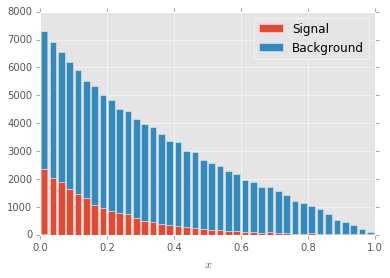

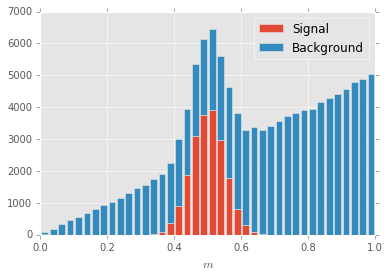

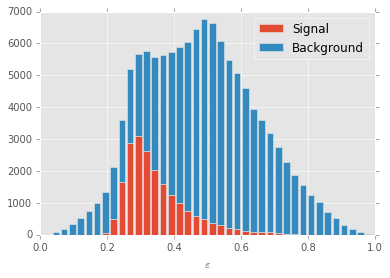

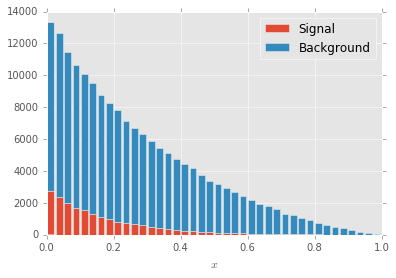

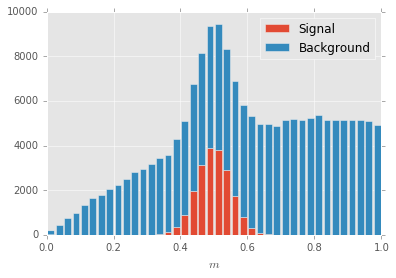

In [2]:
def generate_sx(size):
    xs = -0.2 * np.log(np.random.uniform(size=2 * size))
    xs = xs[xs < 1]
    return xs[:size]


def generate_sm(size):
    return np.random.normal(0.5, 0.05, size=size)


def generate_s(size):
    return np.array([generate_sx(size), generate_sm(size)])


def generate_bx(size):
    return 1 - np.sqrt(np.random.uniform(size=size))


def generate_bm(size):
    return np.sqrt(np.random.uniform(size=size))


def generate_b(size):
    return np.array([generate_bx(size), generate_bm(size)])


def generate_sample(sig_size=20000, bkg_size=100000):
    return np.append(generate_s(sig_size), generate_b(bkg_size), axis=1)


def efficiency(x, m):
    return (x + m) / 2


def generate_with_efficiency(generator, efficiency, size):
    def reset():
        xs, ms = generator(size)
        effs = efficiency(xs, ms)
        accept = np.random.uniform(size=size) > effs
        return np.array([xs[accept], ms[accept]])
    
    sample = reset()
    while sample.shape[1] < size:
        sample = np.append(sample, reset(), axis=1)
    return sample[:size]


def generate_sample_with_efficiency(efficiency, sig_size=20000, bkg_size=100000):
    return np.append(generate_with_efficiency(generate_s, efficiency, sig_size),
                     generate_with_efficiency(generate_b, efficiency, bkg_size),
                     axis=1)


n = 20000
xs, ms = generate_sample()
xs_s, xs_b = xs[:n], xs[n:]
ms_s, ms_b = ms[:n], ms[n:]

plt.hist([xs_s, xs_b], bins=40, histtype='barstacked', label=['Signal', 'Background'])
plt.xlabel(r'$x$')
plt.legend()
plt.show()

plt.hist([ms_s, ms_b], bins=40, histtype='barstacked', label=['Signal', 'Background'])
plt.xlabel(r'$m$')
plt.legend()
plt.show()


effs = efficiency(xs, ms)
effs_s, effs_b = effs[:n], effs[n:]
plt.hist([effs_s, effs_b], bins=40, histtype='barstacked', label=['Signal', 'Background'])
plt.xlabel(r'$\varepsilon$')
plt.legend()
plt.show()

exs, ems = generate_sample_with_efficiency(efficiency)
exs_s, exs_b = exs[:n], exs[n:]
ems_s, ems_b = ems[:n], ems[n:]

plt.hist([exs_s, exs_b], bins=40, histtype='barstacked', label=['Signal', 'Background'])
plt.xlabel(r'$x$')
plt.legend()
plt.show()

plt.hist([ems_s, ems_b], bins=40, histtype='barstacked', label=['Signal', 'Background'])
plt.xlabel(r'$m$')
plt.legend()
plt.show()

---
## Aufgabe 1
Bestimmen Sie für beide Effizienzfunktion die sWeights $w(m)$ aus den beobachteten $m$-Verteilungen, und verwenden Sie $w(m)/\varepsilon(x, m)$ um die Verteilung $N_{s}s(x)$ aus den Daten heraus zu projizieren. Vergleichen Sie für beide Effizienzfunktionen das Resultat mit der Erwartung.

---

Zunächst fitten wir die kombinierte Massenverteilung von Signal und Untergrund an unsere beiden Datensätze. Dabei müssen wir daran denken, die Anzahl Signal- und Untergrundereignissen als Fitparamter zu behandeln. Betrachten wir zuerst den Fall $\varepsilon = 1$.

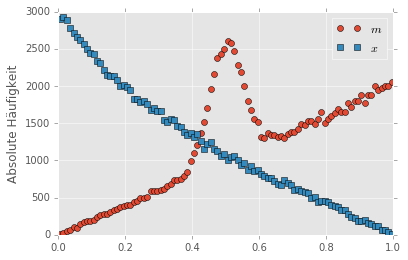

In [3]:
hist, medges, xedges = np.histogram2d(ms, xs, bins=100, range=((0, 1), (0, 1)))
xwidth = xedges[1] - xedges[0]
mwidth = medges[1] - medges[0]
xcentres = xedges[:-1] + xwidth / 2
mcentres = medges[:-1] + mwidth / 2

mhist = np.sum(hist, axis=1)
xhist = np.sum(hist, axis=0)
plt.plot(mcentres, mhist, 'o', label='$m$')
plt.plot(xcentres, xhist, 's', label='$x$')
plt.ylabel('Absolute Häufigkeit')
plt.legend()
plt.show()

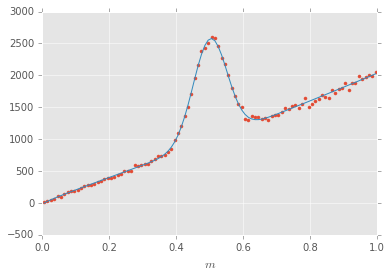

In [4]:
def pdf_ms(m, p0, p1, p2):
    return p0 * np.exp(-(m - p1) ** 2 / 2 / p2 ** 2)
  

def pdf_mb(m, p3, p4, p5, p6):
    return p3 + p4 * m + p5 * m ** 2 + p6 * np.sqrt(m)


def pdf_m(m, p0, p1, p2, p3, p4, p5, p6):
    return pdf_ms(m, p0, p1, p2) + pdf_mb(m, p3, p4, p5, p6)


def fit_mass(centres, ns):
    bwidth = centres[1] - centres[0]
    def f(m, p0, p1, p2, p3, p4, p5, p6):
        return pdf_m(m, p0, p1, p2, p3, p4, p5, p6)
    popt, pcov = curve_fit(f, centres, ns, p0=[20000, 0.5, 0.5, 100000, 0.1, 0, 1])
    return popt, pcov


popt, _ = fit_mass(mcentres, mhist)

plt.plot(mcentres, mhist, '.')
plt.plot(mcentres, pdf_m(mcentres, *popt))
plt.xlabel('$m$')
plt.show()

Als nächstes können wir mit Hilfe der bestimmten Parameter die sWeights bestimmen.

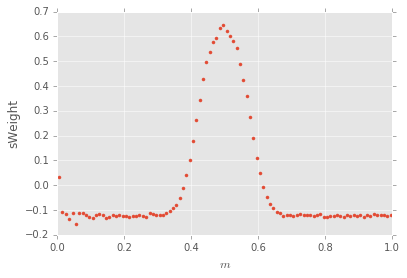

In [5]:
def sweights(centres, mhist, popt):
    bw = centres[1] - centres[0]
    s = pdf_ms(centres, *popt[:3])
    b = pdf_mb(centres, *popt[3:])
    n = mhist

    Wss = np.sum(bw * (s * s) / n)
    Wsb = np.sum(bw * (s * b) / n)
    Wbb = np.sum(bw * (b * b) / n)
    alpha = Wbb / (Wss * Wbb - Wsb ** 2)
    beta = -Wsb / (Wss * Wbb - Wsb ** 2)
    weights = (alpha * s + beta * b) / n / bw
    return weights


sw = sweights(mcentres, mhist, popt)

plt.plot(mcentres, sw, '.')
plt.xlabel('$m$')
plt.ylabel('sWeight')
plt.show()

Diese können wir nun verwenden, um die Signalkomponente $s(x)$ herauszuprojizieren.

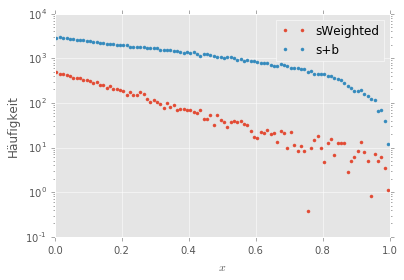

In [6]:
xweighted = np.array([w * h for w, h in zip(sw, hist)]).sum(axis=0)
plt.plot(xcentres, xweighted, '.', label='sWeighted')
plt.plot(xcentres, xhist, '.', label='s+b')
plt.xlabel('$x$')
plt.ylabel('Häufigkeit')
plt.yscale('log')
plt.legend()
plt.show()

Die gleiche Rechnung machen wir jetzt für $\varepsilon = (x + m) / 2$ wobei wir absichtlich die falschen sWeights verwenden.

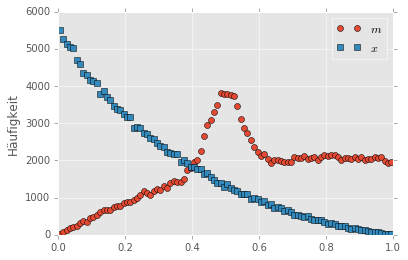

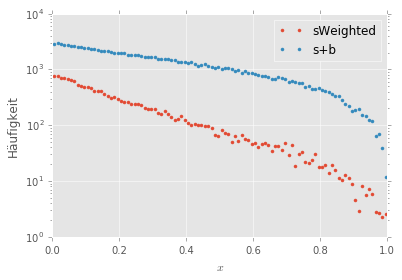

In [8]:
eeffs = efficiency(exs, ems)
ehist, emedges, exedges = np.histogram2d(ems, exs, bins=100, range=((0, 1), (0, 1)))
exwidth = exedges[1] - exedges[0]
emwidth = emedges[1] - emedges[0]
excentres = exedges[:-1] + exwidth / 2
emcentres = emedges[:-1] + emwidth / 2

eeffhist = np.array([[efficiency(x, m) for m in emcentres] for x in excentres])
emeffhist = np.sum(eeffhist, axis=1)
exeffhist = np.sum(eeffhist, axis=0)

emhist = np.sum(ehist, axis=1)
exhist = np.sum(ehist, axis=0)
plt.plot(emcentres, emhist, 'o', label='$m$')
plt.plot(excentres, exhist, 's', label='$x$')
plt.ylabel('Häufigkeit')
plt.legend()
plt.show()

xweighted = np.array([w * h for w, h in zip(sw, ehist)]).sum(axis=0)
plt.plot(xcentres, xweighted, '.', label='sWeighted')
plt.plot(xcentres, xhist, '.', label='s+b')
plt.xlabel('$x$')
plt.ylabel('Häufigkeit')
plt.yscale('log')
plt.legend()
plt.show()

---
## Aufgabe 2
Bestimmen Sie für $\varepsilon(x, m) = (x + m)/2$ unter Berücksichtigung der Funktion $\varepsilon(x, m)$ in der Bestimmung von $w(m)$ die korrekten sWeights aus den mit $1/\varepsilon(x, m)$ gewichteten Daten. Verwenden Sie die korrekten sWeights um mit $w(m)/\varepsilon(x, m)$ um die Verteilung $N_{s}s(x)$ zu extrahieren.

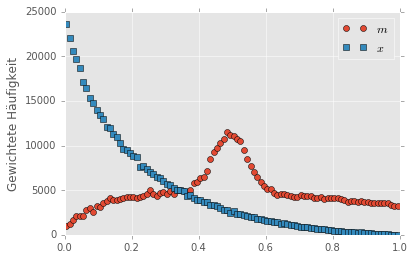

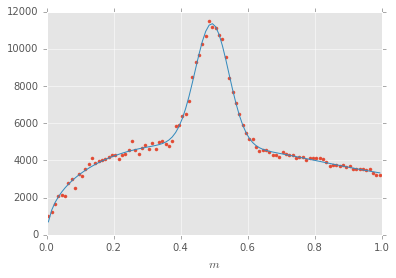

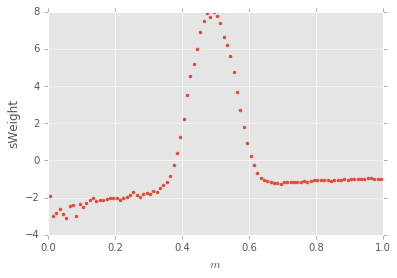

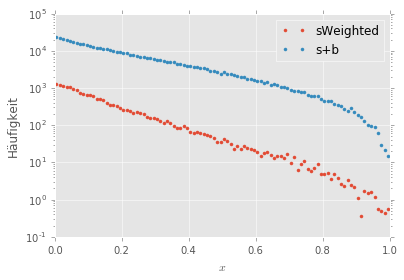

In [9]:
eeffs = efficiency(exs, ems)
ehist, emedges, exedges = np.histogram2d(ems, exs, bins=100, range=((0, 1), (0, 1)), weights=1/eeffs)
exwidth = exedges[1] - exedges[0]
emwidth = emedges[1] - emedges[0]
excentres = exedges[:-1] + exwidth / 2
emcentres = emedges[:-1] + emwidth / 2

eeffhist = np.array([[efficiency(x, m) for m in emcentres] for x in excentres])
emeffhist = np.sum(eeffhist, axis=1)
exeffhist = np.sum(eeffhist, axis=0)

emhist = np.sum(ehist, axis=1)
exhist = np.sum(ehist, axis=0)
plt.plot(emcentres, emhist, 'o', label='$m$')
plt.plot(excentres, exhist, 's', label='$x$')
plt.ylabel('Gewichtete Häufigkeit')
plt.legend()
plt.show()

def fit_mass_eff(centres, ns, effs):
    bwidth = centres[1] - centres[0]
    def f(m, p0, p1, p2, p3, p4, p5, p6):
        return effs * pdf_m(m, p0, p1, p2, p3, p4, p5, p6)
    popt, pcov = curve_fit(f, centres, ns, p0=[20000, 0.5, 0.5, 1000, 10, -1, 1])
    return popt, pcov


epopt, _ = fit_mass_eff(emcentres, emhist, emeffhist)

plt.plot(emcentres, emhist, '.')
plt.plot(emcentres, pdf_m(emcentres, *epopt) * emeffhist)
plt.xlabel('$m$')
plt.show()

esw = sweights(emcentres, emhist, epopt)

plt.plot(emcentres, esw, '.')
plt.xlabel('$m$')
plt.ylabel('sWeight')
plt.show()

exweighted = np.array([w * h for w, h in zip(esw, ehist)]).sum(axis=0) / emeffhist
plt.plot(excentres, exweighted, '.', label='sWeighted')
plt.plot(excentres, exhist, '.', label='s+b')
plt.xlabel('$x$')
plt.ylabel('Häufigkeit')
plt.yscale('log')
plt.legend()
plt.show()